In [2]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import geopandas as gpd
import cufflinks as cf
import matplotlib.pyplot as plt
from libpysal.weights import Kernel
from scipy.spatial import distance_matrix

cf.go_offline()
data_dir = Path('../data/processed')
data = gpd.read_file(data_dir / 'spatial_income_1880.gpkg')
# print(data.loc[data.orthodox_proportion.isna()])
data = data.dropna().reset_index()
# W = Kernel.from_dataframe(data, fixed=True, bandwidth=150, function='quartic')
xy = np.array([data.geometry.x, data.geometry.y]).T
d = distance_matrix(xy, xy)
d_norm = d / d.max()
n = data.shape[0]

<AxesSubplot:>

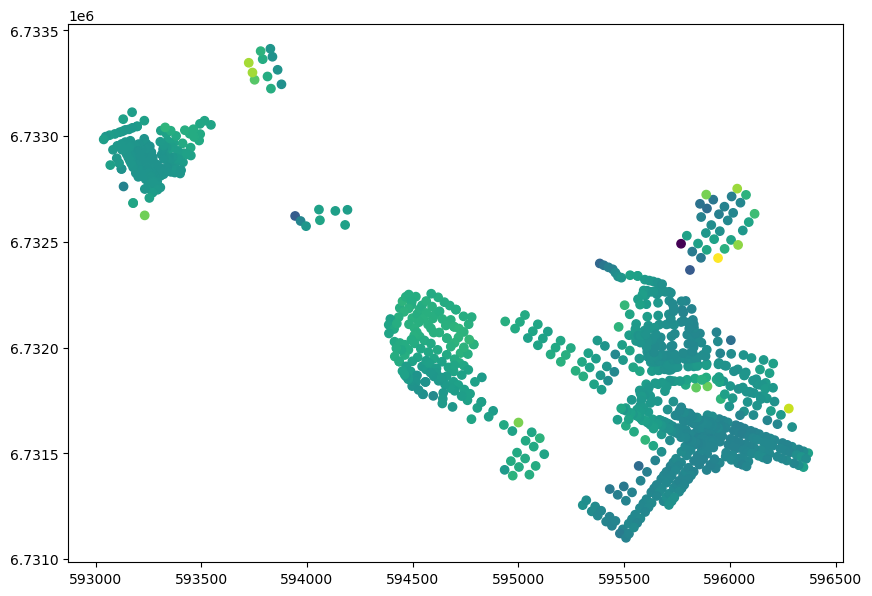

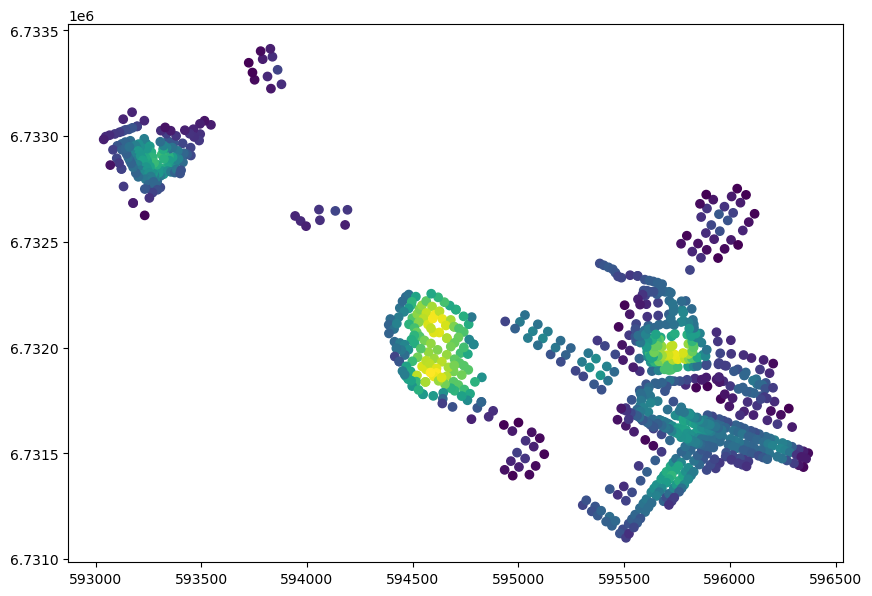

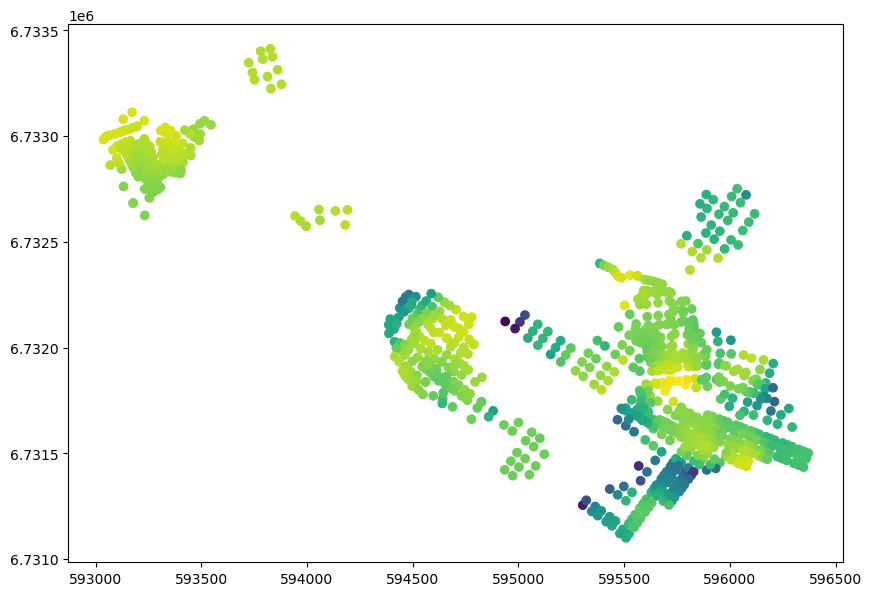

In [19]:
data.plot(column='income_per_capita_ln', figsize=(10,10))
data.plot(column='population', figsize=(10,10))
data.plot(column='orthodox_proportion_ln', figsize=(10,10))

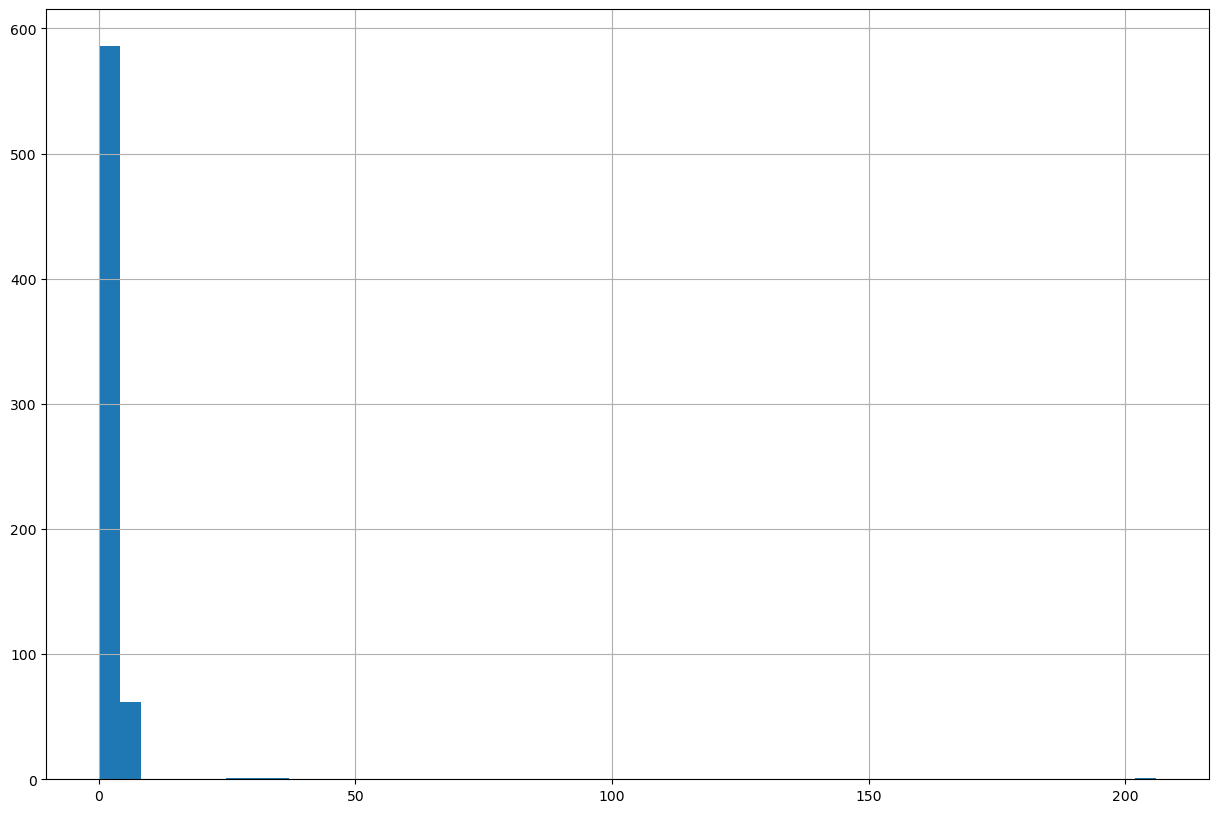

array([[<AxesSubplot:title={'center':'orthodox_proportion_ln'}>]],
      dtype=object)

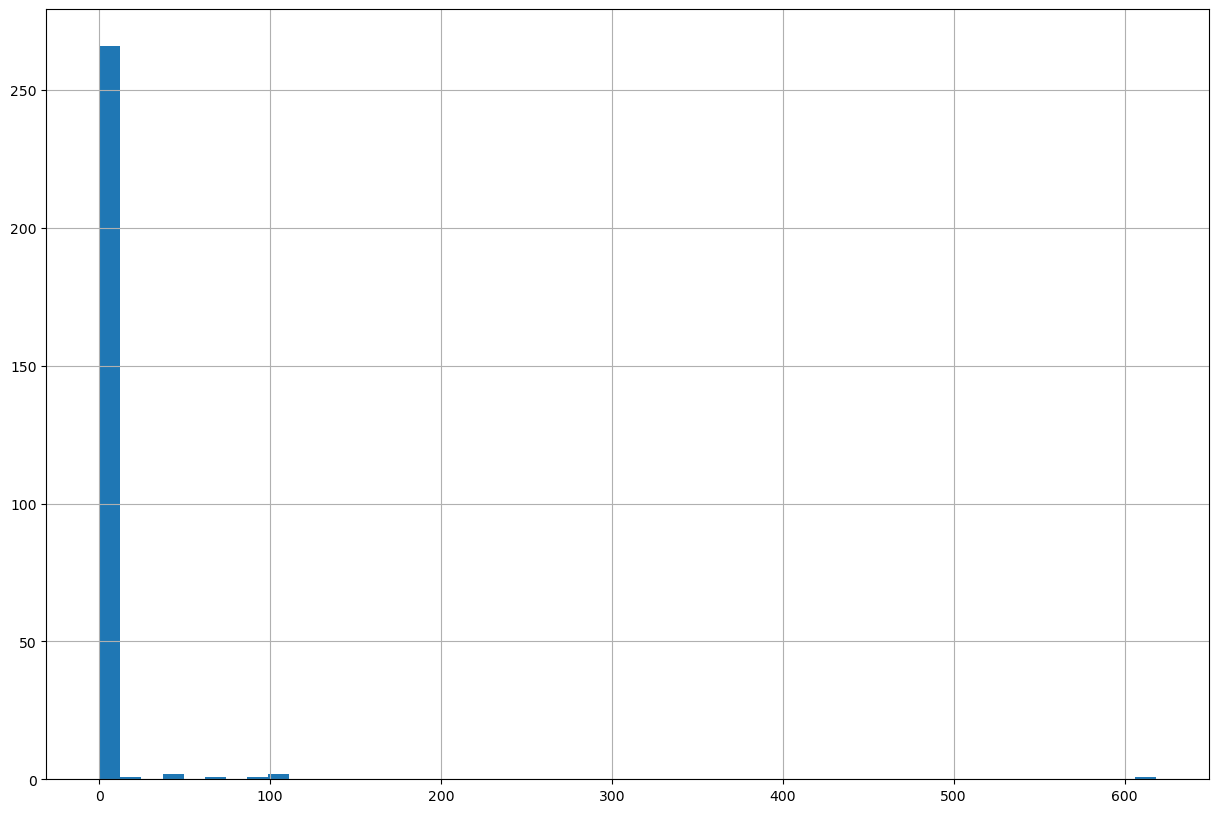

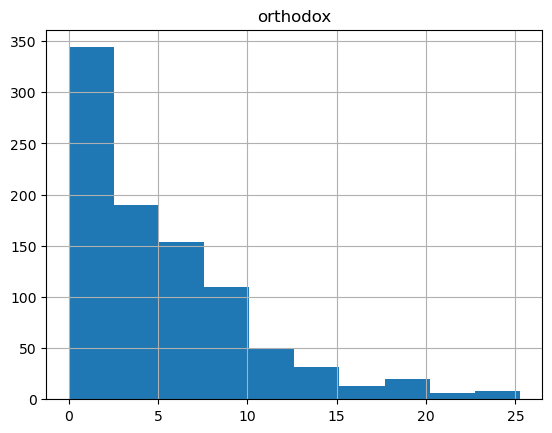

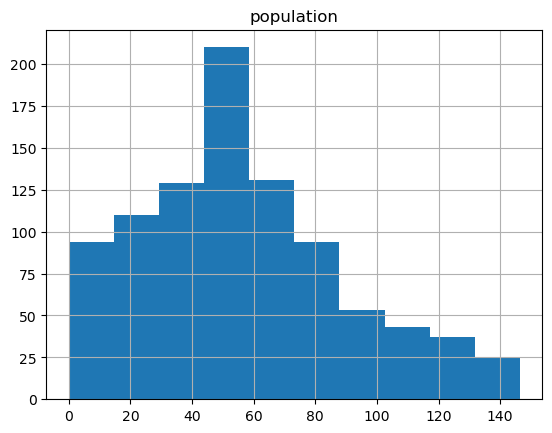

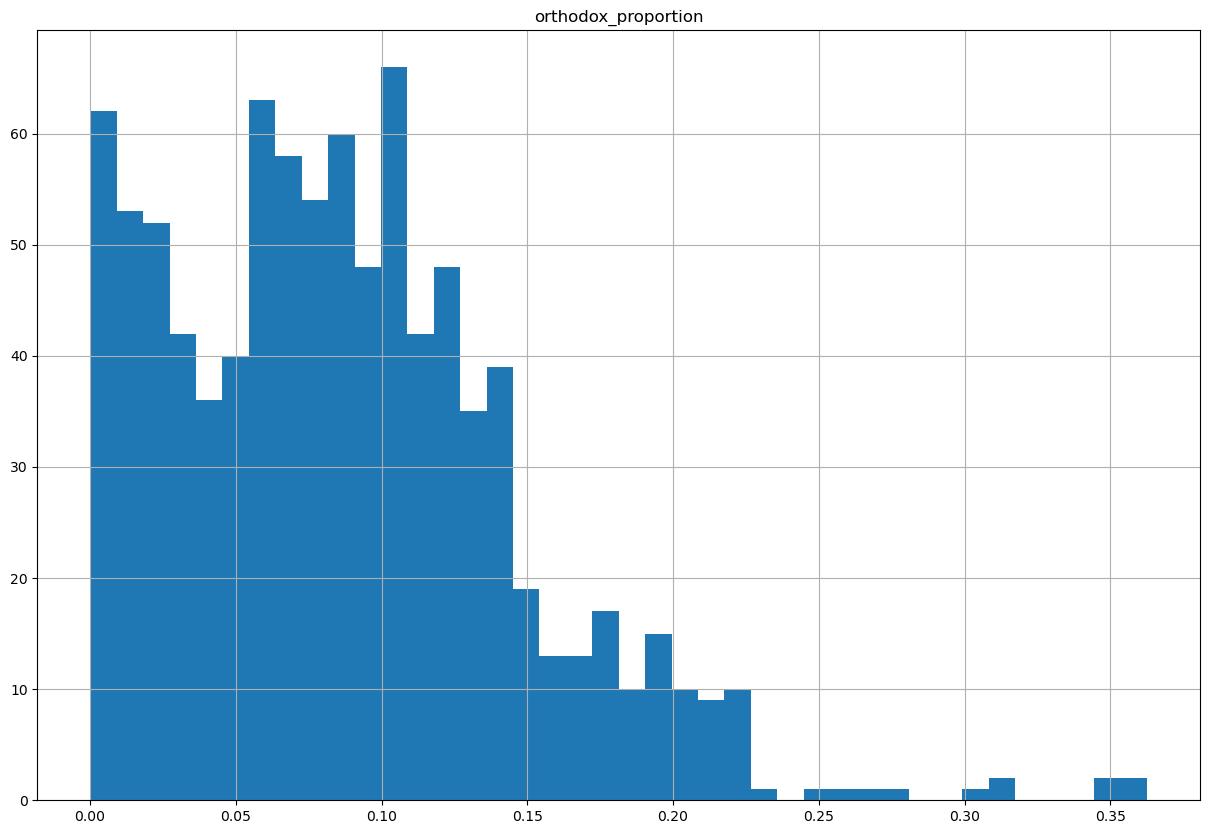

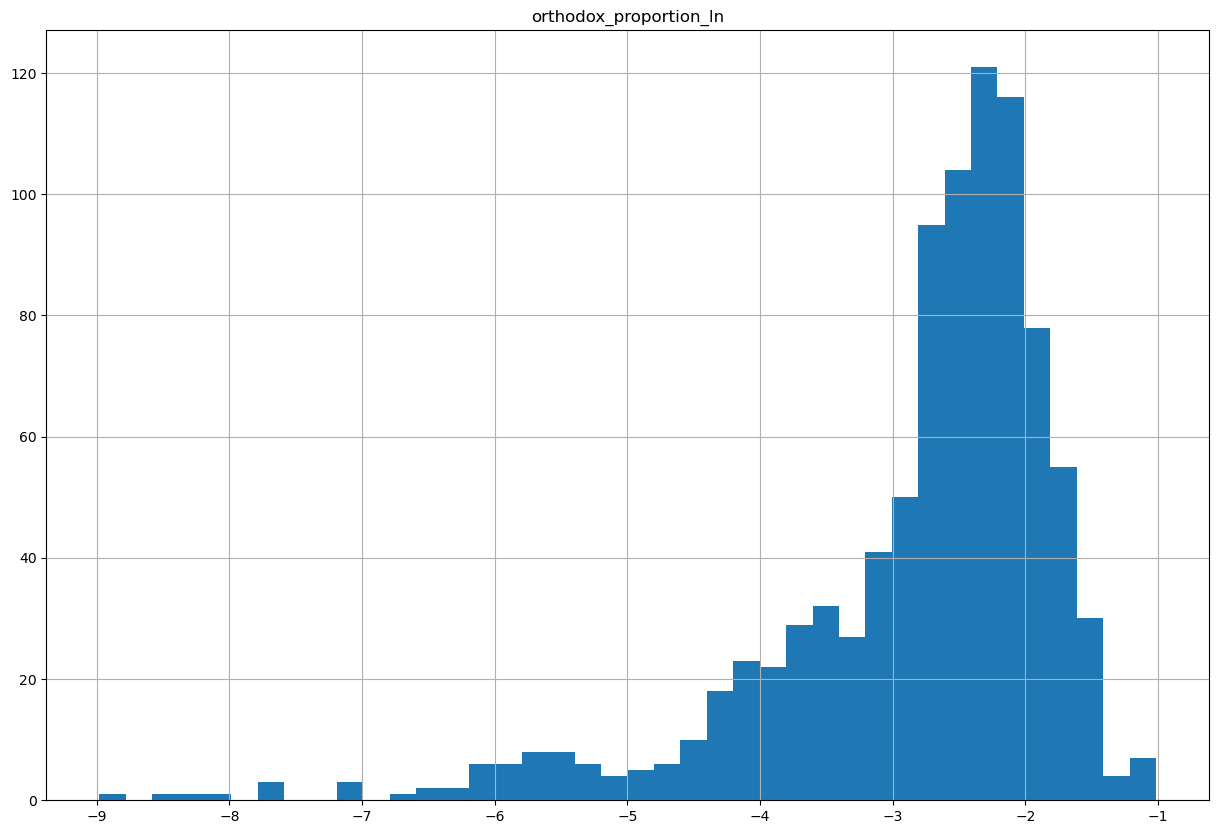

In [20]:
data.loc[data.is_old,'income_per_capita'].hist(figsize=(15,10), bins=50)
plt.show()
data.loc[~data.is_old,'income_per_capita'].hist(figsize=(15,10), bins=50)
data.hist(column='orthodox')
data.hist(column='population')
data.hist(column='orthodox_proportion', figsize=(15, 10), bins=40)
data.hist(column='orthodox_proportion_ln', figsize=(15, 10), bins=40)
# data.hist(column='orthodox')
# data.hist(column='lutheran')
# data.iplot(x='total_income', y='total_density', kind='scatter', mode='markers')

In [21]:
# with pm.Model() as model_1:
#     F = pm.ConstantData('F', data.is_old.astype('int'))
#
#     mu_beta_W = np.array([4, 1])
#     sigma_beta_W = np.array(np.diagflat([1, 1]))
#     beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
#     sigma_W = pm.HalfNormal('sigma_W', sigma=1)
#     ln_W = pm.StudentT('ln_W', nu=1, mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.total_income_ln)
#
#     mu_beta_O = np.array([0., 0., 0.])
#     mu_beta_L = np.array([0., 0., 0.])
#     sigma_beta_O = np.array(np.diagflat([0.25, 0.25, 0.25]))
#     sigma_beta_L = np.array(np.diagflat([0.25, 0.25, 0.25]))
#
#     beta_O = pm.MvNormal('beta_O', mu_beta_O, sigma_beta_O, shape=3)
#     beta_L = pm.MvNormal('beta_L', mu_beta_L, sigma_beta_L, shape=3)
#     sigma_O = pm.HalfNormal('sigma_O', 10)
#     sigma_L = pm.HalfNormal('sigma_L', 10)
#
#     O = pm.Normal('O', beta_O[0] + beta_O[1] * F + beta_O[2] * ln_W, sigma_O, observed=data.orthodox)
#     L = pm.Normal('L', beta_L[0] + beta_L[1] * F + beta_L[2] * ln_W, sigma_L, observed=data.lutheran)
#
#     prior = pm.sample_prior_predictive()
#     posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
#     posterior_prediction = pm.sample_posterior_predictive(posterior)
#
# az.plot_posterior(posterior)
# az.plot_trace(posterior)
# az.plot_forest(posterior, combined=False, hdi_prob=0.94)
# pm.model_to_graphviz(model_1)

In [22]:
# with pm.Model() as model_2:
#     F = pm.ConstantData('F', data.is_old.astype('int'))
#
#     mu_beta_W = np.array([4, 1])
#     sigma_beta_W = np.array(np.diagflat([1, 1]))
#     beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
#     sigma_W = pm.HalfNormal('sigma_W', sigma=1)
#     ln_W = pm.StudentT('ln_W', nu=1, mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.total_income_ln)
#
#     mu_beta_O_prop = np.array([0.1, 0.1, 0.1])
#     mu_beta_P = np.array([0., 0., 0.])
#     sigma_beta_O_prop = np.array(np.diagflat([0.1, 0.1, 0.1]))
#     sigma_beta_P = np.array(np.diagflat([0.25, 0.25, 0.25]))
#
#     beta_O_prop = pm.MvNormal('beta_O_prop', mu_beta_O_prop, sigma_beta_O_prop, shape=3)
#     beta_P = pm.MvNormal('beta_P', mu_beta_L, sigma_beta_L, shape=3)
#     sigma_O_prop = pm.HalfNormal('sigma_O_prop', 0.05)
#     sigma_P = pm.HalfNormal('sigma_P', 50)
#     P = pm.Normal('P', beta_P[0] + beta_P[1] * F + beta_P[2] * ln_W, sigma_P, observed=data.population)
#
#     mu_O_prop = beta_O_prop[0] + beta_O_prop[1] * F + beta_O_prop[2] * ln_W
#     O_prop = pm.TruncatedNormal('O_prop', mu=mu_O_prop, sigma=sigma_O_prop, lower=0, upper=1, observed=data.orthodox_proportion)
#
#     prior = pm.sample_prior_predictive()
#     posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
#     posterior_prediction = pm.sample_posterior_predictive(posterior)
#
# az.plot_posterior(posterior)
# az.plot_trace(posterior)
# az.plot_forest(posterior, combined=False, hdi_prob=0.94)
# pm.model_to_graphviz(model_2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_O, β_P, σ_O, σ_P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


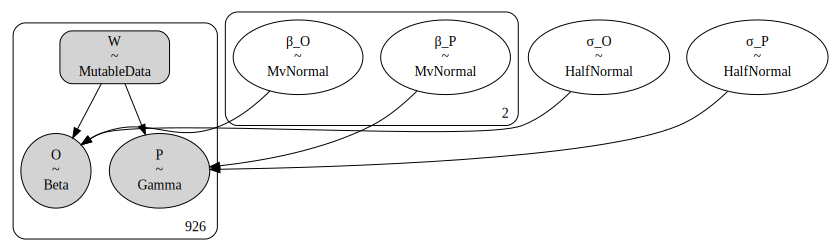

In [23]:
with pm.Model() as model_1:
    W = pm.MutableData('W', data.income_per_capita)

    μ_β_O = np.array([0, 0])
    σ_β_O = np.array(np.diagflat([0.1, 0.1]))

    μ_β_P = np.array([0., 0.])
    σ_β_P = np.array(np.diagflat([0.1, 0.1]))

    β_O = pm.MvNormal('β_O', μ_β_O, σ_β_O, shape=2)
    β_P = pm.MvNormal('β_P', μ_β_P, σ_β_P, shape=2)
    σ_O = pm.HalfNormal('σ_O', 0.1)
    σ_P = pm.HalfNormal('σ_P', 0.1)

    P = pm.Gamma('P', pm.math.exp(β_P[0] + β_P[1] * W), σ_P, observed=data.population)

    μ_O = pm.math.exp(β_O[0] + β_O[1] * W)
    O = pm.Beta('O', μ_O, σ_O, observed=data.orthodox_proportion)

    prior_1 = pm.sample_prior_predictive()
    posterior_1 = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction_1 = pm.sample_posterior_predictive(posterior_1)

graph_1 = pm.model_to_graphviz(model_1)
graph_1

array([<AxesSubplot:xlabel='P / P'>, <AxesSubplot:xlabel='O / O'>],
      dtype=object)

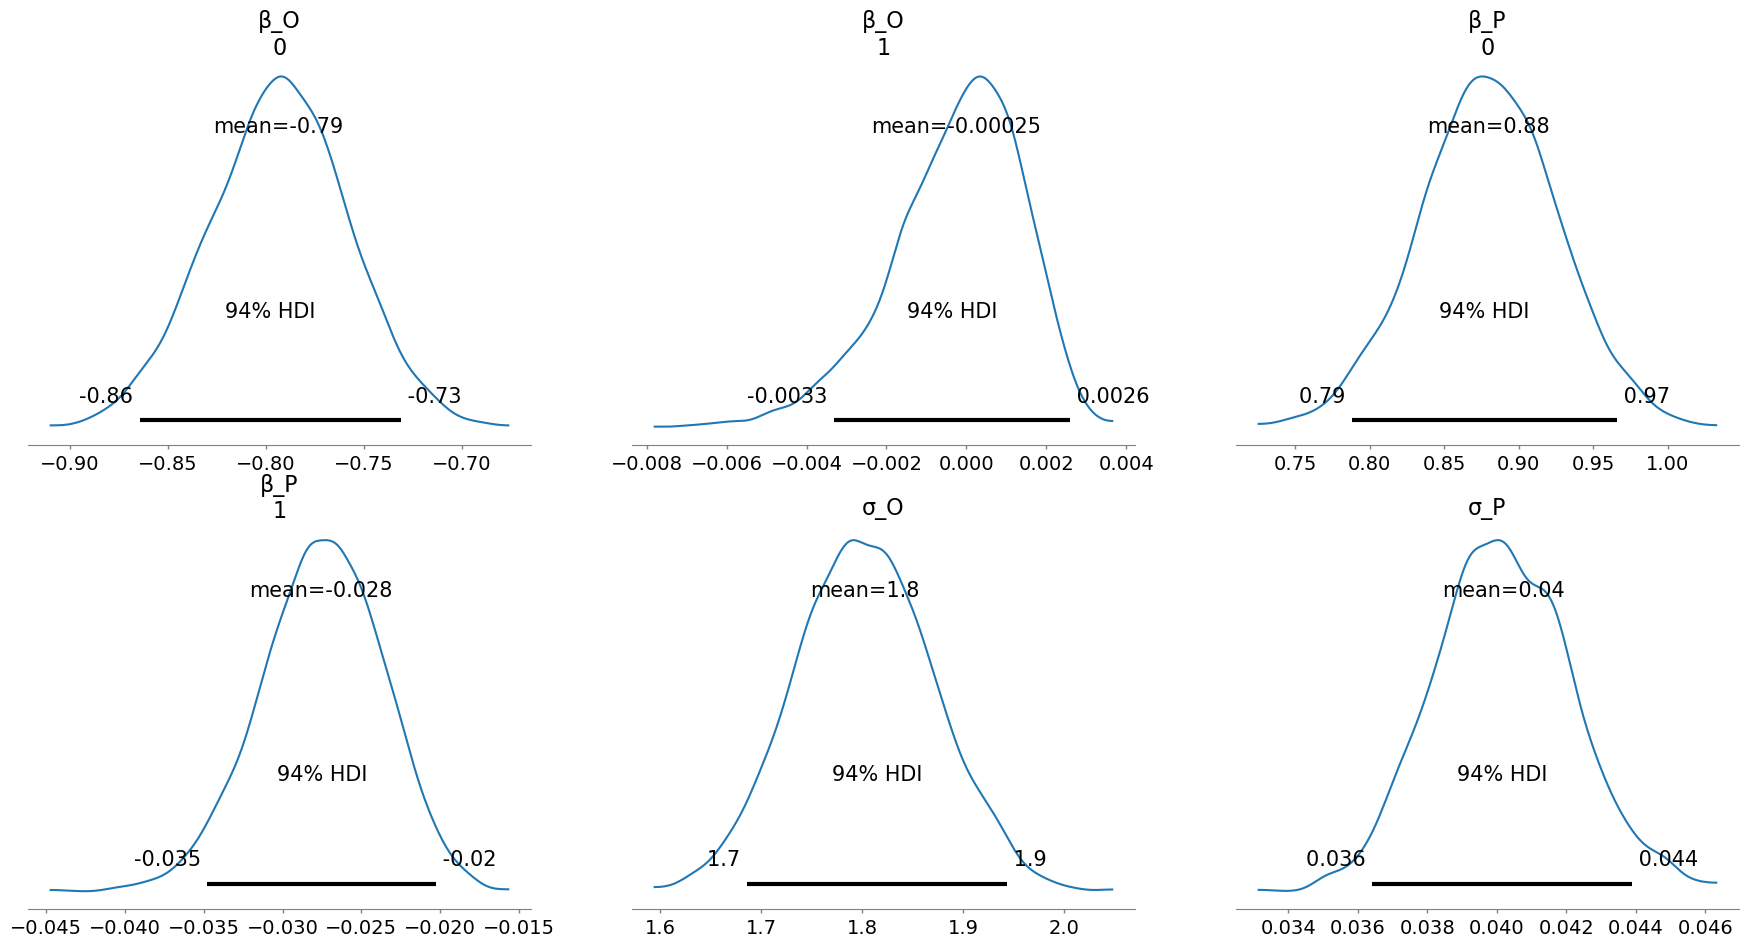

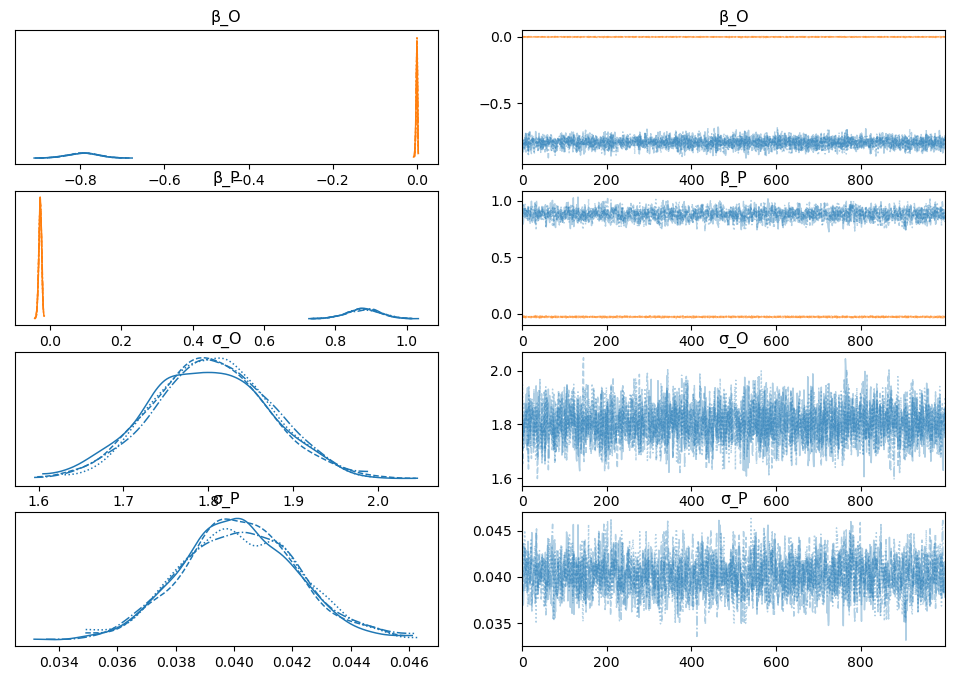

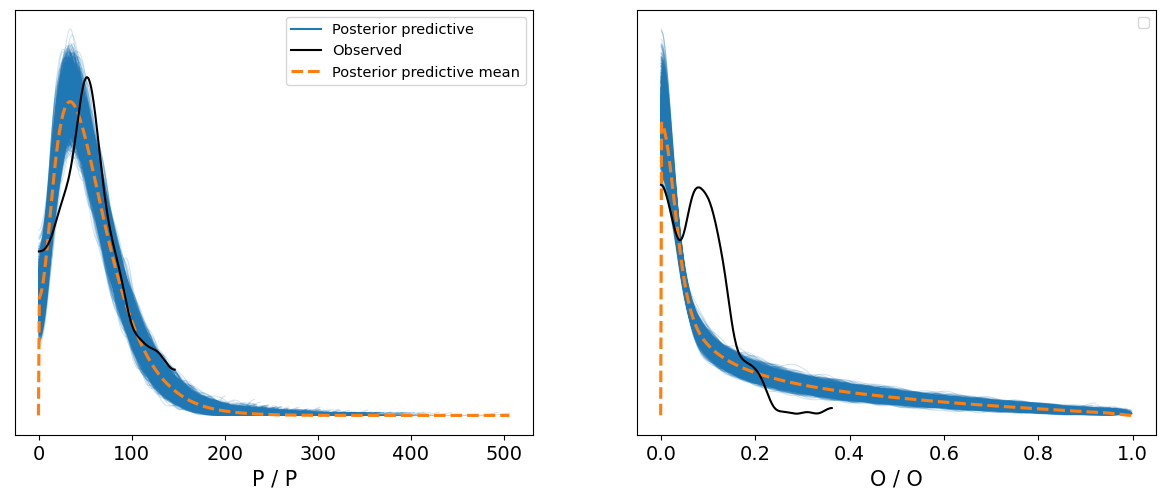

In [24]:
az.plot_posterior(posterior_1)
az.plot_trace(posterior_1)
# az.plot_forest(posterior_1, combined=False, hdi_prob=0.94)

az.plot_ppc(posterior_prediction_1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_W, σ_W, β_O, β_P, σ_O, σ_P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


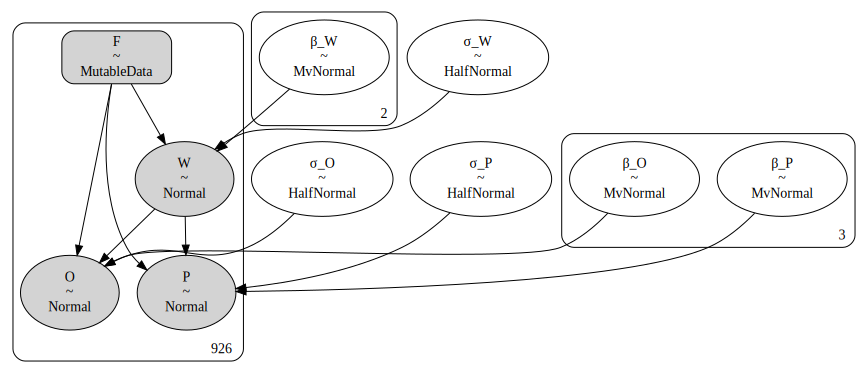

In [29]:
with pm.Model() as model_2:
    F = pm.MutableData('F', data.is_old.astype('int'))

    μ_β_W = np.array([0, 0])
    σ_β_W = np.array(np.diagflat([1, 1]))
    β_W = pm.MvNormal('β_W', μ_β_W, σ_β_W, shape=2)
    σ_W = pm.HalfNormal('σ_W', 1)
    W = pm.Normal('W', β_W[0] + β_W[1] * F, σ_W, observed=data.income_per_capita_ln)

    μ_β_O = np.array([0, 0, 0])
    σ_β_O = np.array(np.diagflat([0.1, 0.1, 0.1]))

    μ_β_P = np.array([0., 0., 0.])
    σ_β_P = np.array(np.diagflat([0.1, 0.1, 0.1]))

    β_O = pm.MvNormal('β_O', μ_β_O, σ_β_O, shape=3)
    β_P = pm.MvNormal('β_P', μ_β_P, σ_β_P, shape=3)
    σ_O = pm.HalfNormal('σ_O', 1)
    σ_P = pm.HalfNormal('σ_P', 1)

    P = pm.Normal('P', β_P[0] + β_P[1] * F + β_P[2] * W, σ_P, observed=data.population_ln)

    μ_O = β_O[0] + β_O[1] * F + β_O[2] * W
    O = pm.Normal('O', μ_O, σ_O, observed=data.orthodox_proportion_ln)

    prior_2 = pm.sample_prior_predictive()
    posterior_2 = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction_2 = pm.sample_posterior_predictive(posterior_2)

graph_2 = pm.model_to_graphviz(model_2)
graph_2

array([<AxesSubplot:xlabel='W / W'>, <AxesSubplot:xlabel='P / P'>,
       <AxesSubplot:xlabel='O / O'>], dtype=object)

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



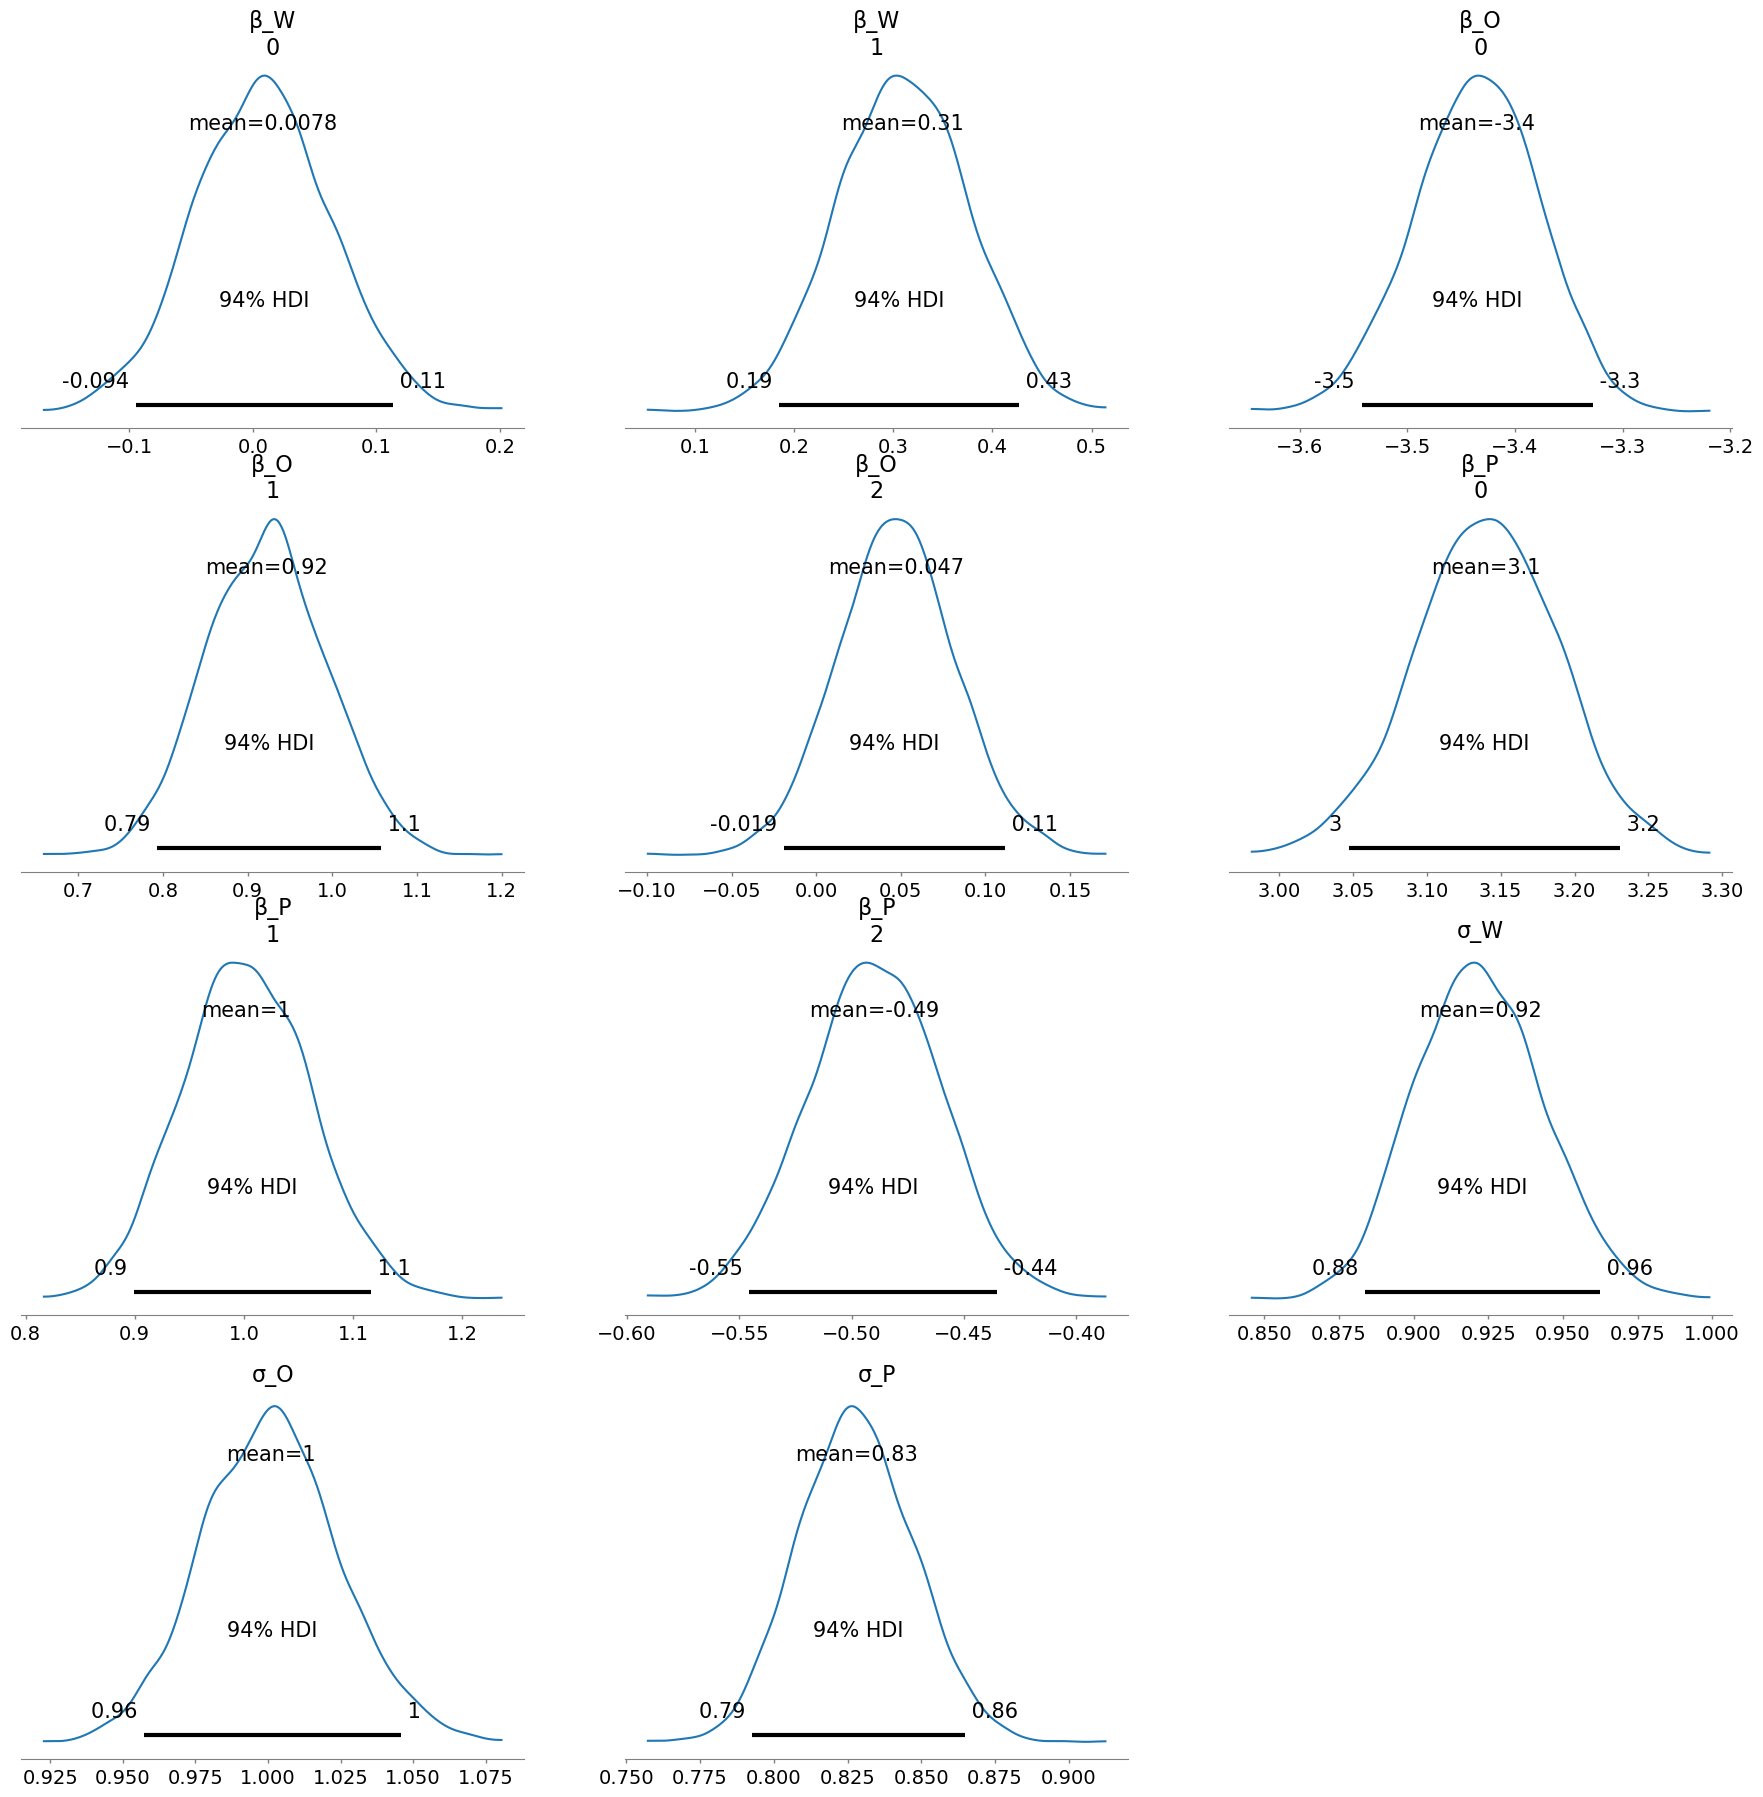

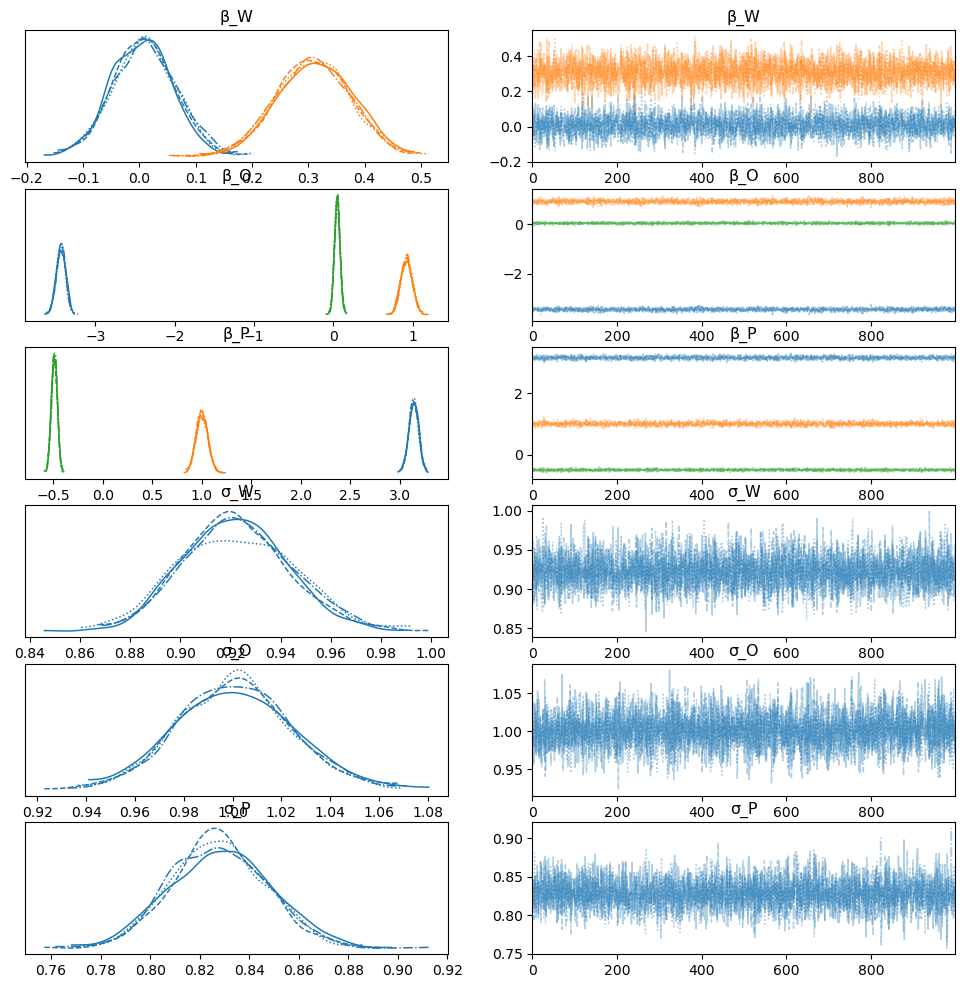

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



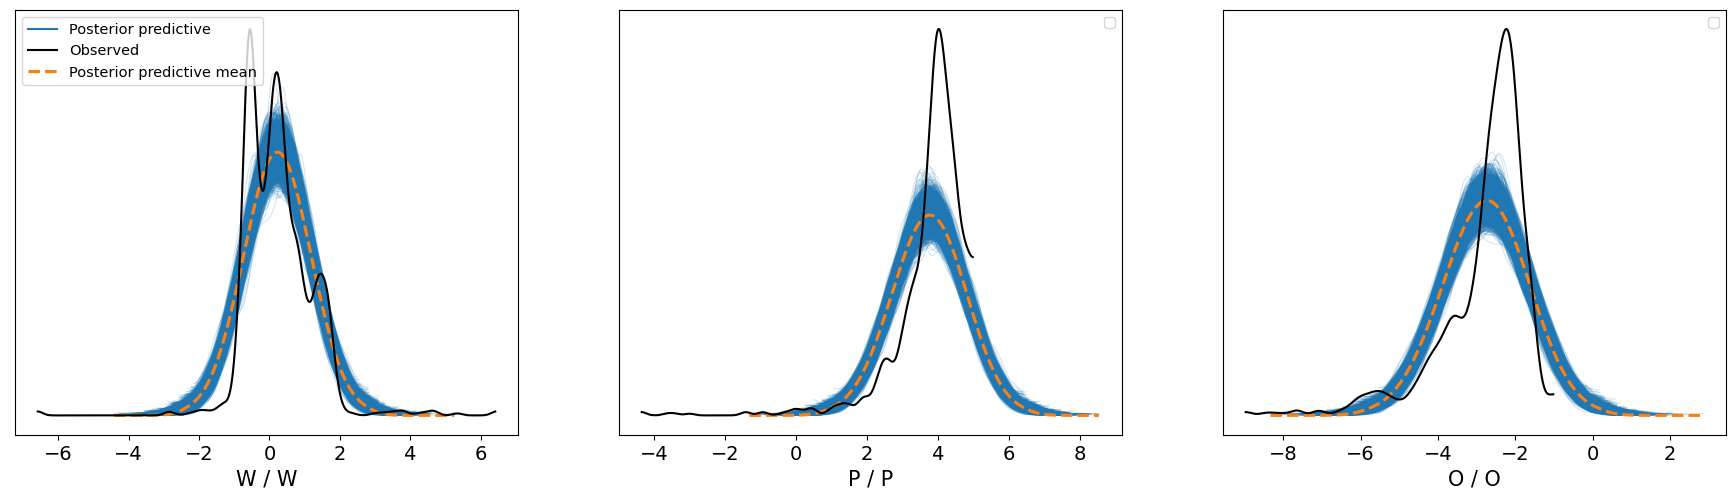

In [30]:
az.plot_posterior(posterior_2)
az.plot_trace(posterior_2)
# az.plot_forest(posterior_2, combined=False, hdi_prob=0.94)

az.plot_ppc(posterior_prediction_2)

<AxesSubplot:>

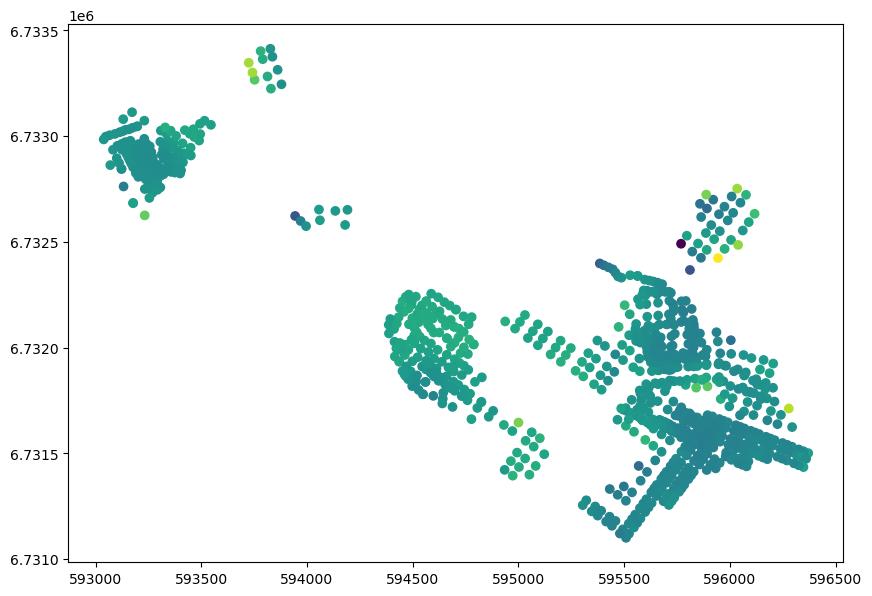

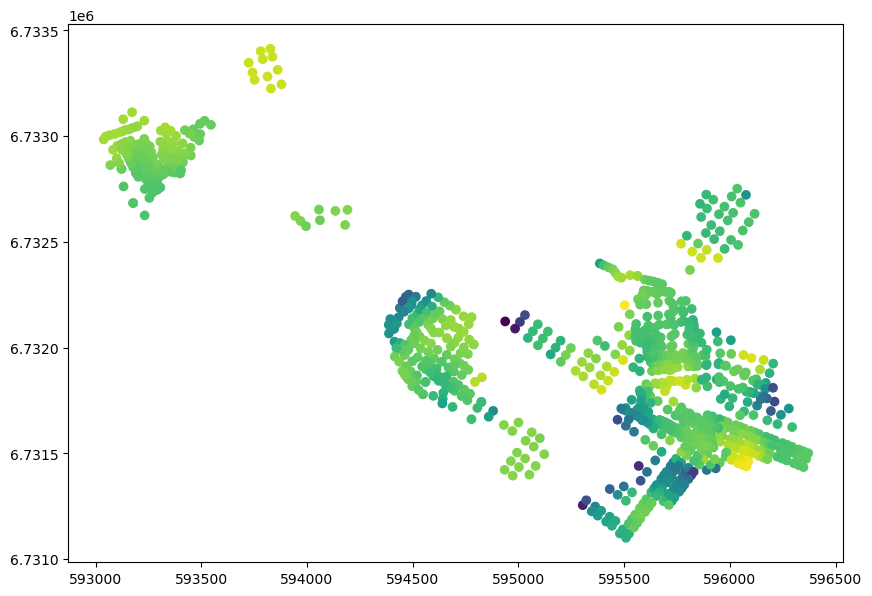

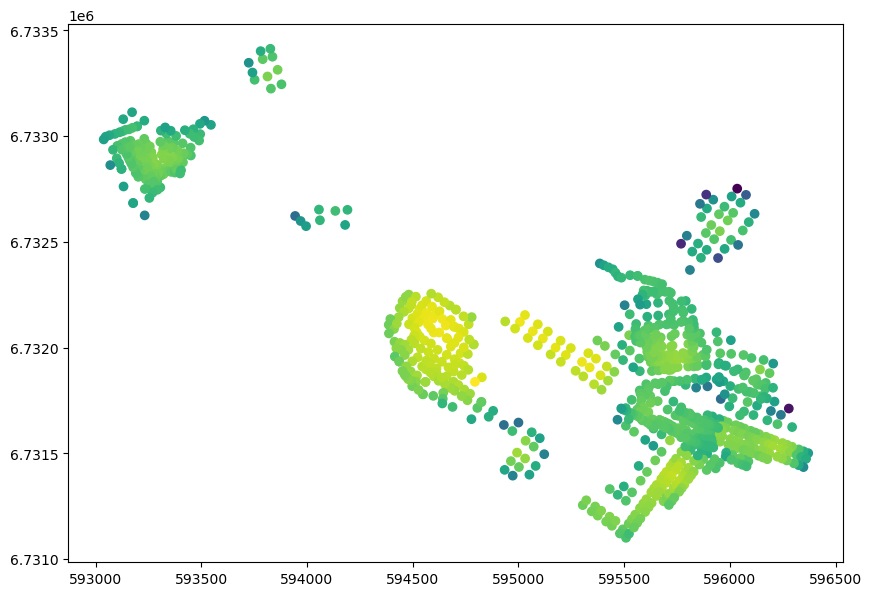

In [27]:
# Residuals

data['W_residual'] = data.income_per_capita_ln - 0.31 * data.is_old
data.plot(column='W_residual', figsize=(10, 10))

data['O_residual'] = data.orthodox_proportion_ln - (-3.4 + 0.94 * data.is_old)
data.plot(column='O_residual', figsize=(10, 10))

data['P_residual'] = data.population_ln - (3.1 + data.is_old - 0.49 * data.income_per_capita_ln)
data.plot(column='P_residual', figsize=(10, 10))

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.10/site-packages/pymc/gp/cov.py:99: UserWarning:

Only 1 column(s) out of 926 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_W, ρ_W, β_W, σ_W, σ_O, σ_P, ε_W_rotated_, β_O, β_P, ε_O_rotated_, ε_P_rotated_]


Sampling 4 chains for 100 tune and 190 draw iterations (400 + 760 draws total) took 330660 seconds.


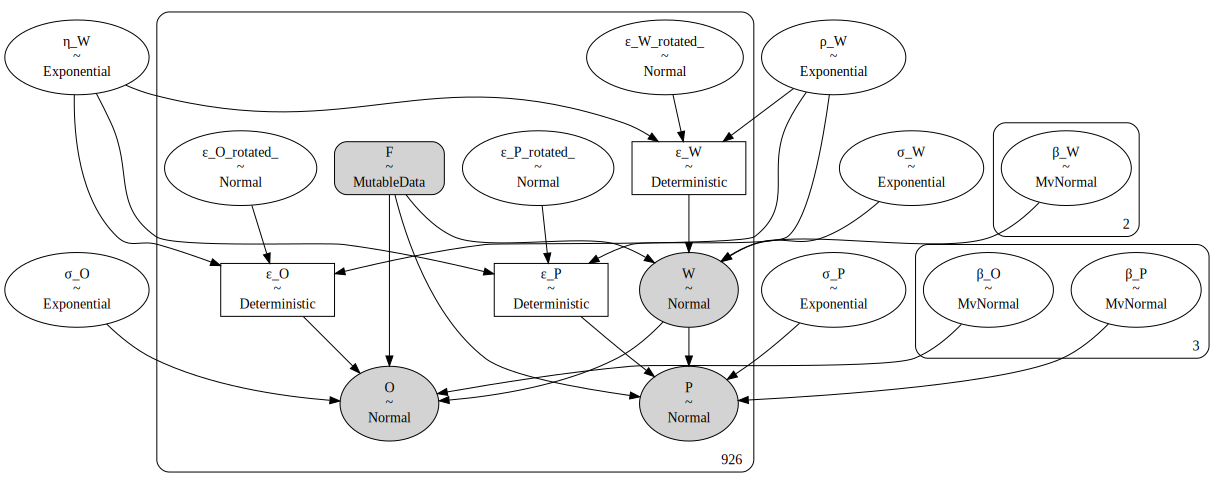

In [ ]:
with pm.Model() as model_3:
    F = pm.MutableData('F', data.is_old.astype('int'))
    idx = data.index.values

    η = pm.Exponential('η_W', 0.5)
    ρ = pm.Exponential('ρ_W', 0.5)
    K = η * pm.gp.cov.ExpQuad(1, ls=ρ)

    μ_β_W = np.array([0, 0])
    σ_β_W = np.array(np.diagflat([1, 1]))
    β_W = pm.MvNormal('β_W', μ_β_W, σ_β_W, shape=2)

    σ_W = pm.Exponential('σ_W', 0.1)
    σ_O = pm.Exponential('σ_O', 0.1)
    σ_P = pm.Exponential('σ_P', 0.1)

    ε_W = pm.gp.Latent(cov_func=K).prior('ε_W', X=d_norm)
    W = pm.Normal('W', β_W[0] + β_W[1] * F + ε_W[idx], σ_W, observed=data.income_per_capita_ln)

    μ_β_O = np.array([0, 0, 0])
    σ_β_O = np.array(np.diagflat([0.1, 0.1, 0.1]))

    μ_β_P = np.array([0., 0., 0.])
    σ_β_P = np.array(np.diagflat([0.1, 0.1, 0.1]))

    β_O = pm.MvNormal('β_O', μ_β_O, σ_β_O, shape=3)
    β_P = pm.MvNormal('β_P', μ_β_P, σ_β_P, shape=3)

    ε_O = pm.gp.Latent(cov_func=K).prior('ε_O', X=d_norm)
    O = pm.Normal('O', β_O[0] + β_O[1] * F + β_O[2] * W + ε_O[idx], σ_O, observed=data.orthodox_proportion_ln)

    ε_P = pm.gp.Latent(cov_func=K).prior('ε_P', X=d_norm)
    P = pm.Normal('P', β_P[0] + β_P[1] * F + β_P[2] * W + ε_P[idx], σ_P, observed=data.population_ln)

    prior_3 = pm.sample_prior_predictive()
    posterior_3 = pm.sample(draws=500, tune=100, init="adapt_diag", return_inferencedata=True, target_accept=0.9)
    posterior_prediction_3 = pm.sample_posterior_predictive(posterior_3)

graph_3 = pm.model_to_graphviz(model_3)
graph_3

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.10/site-packages/arviz/plots/plot_utils.py:271: UserWarning:

rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (5569) in plot_posterior, generating only 40 plots



array([<AxesSubplot:xlabel='W / W'>, <AxesSubplot:xlabel='O / O'>,
       <AxesSubplot:xlabel='P / P'>], dtype=object)

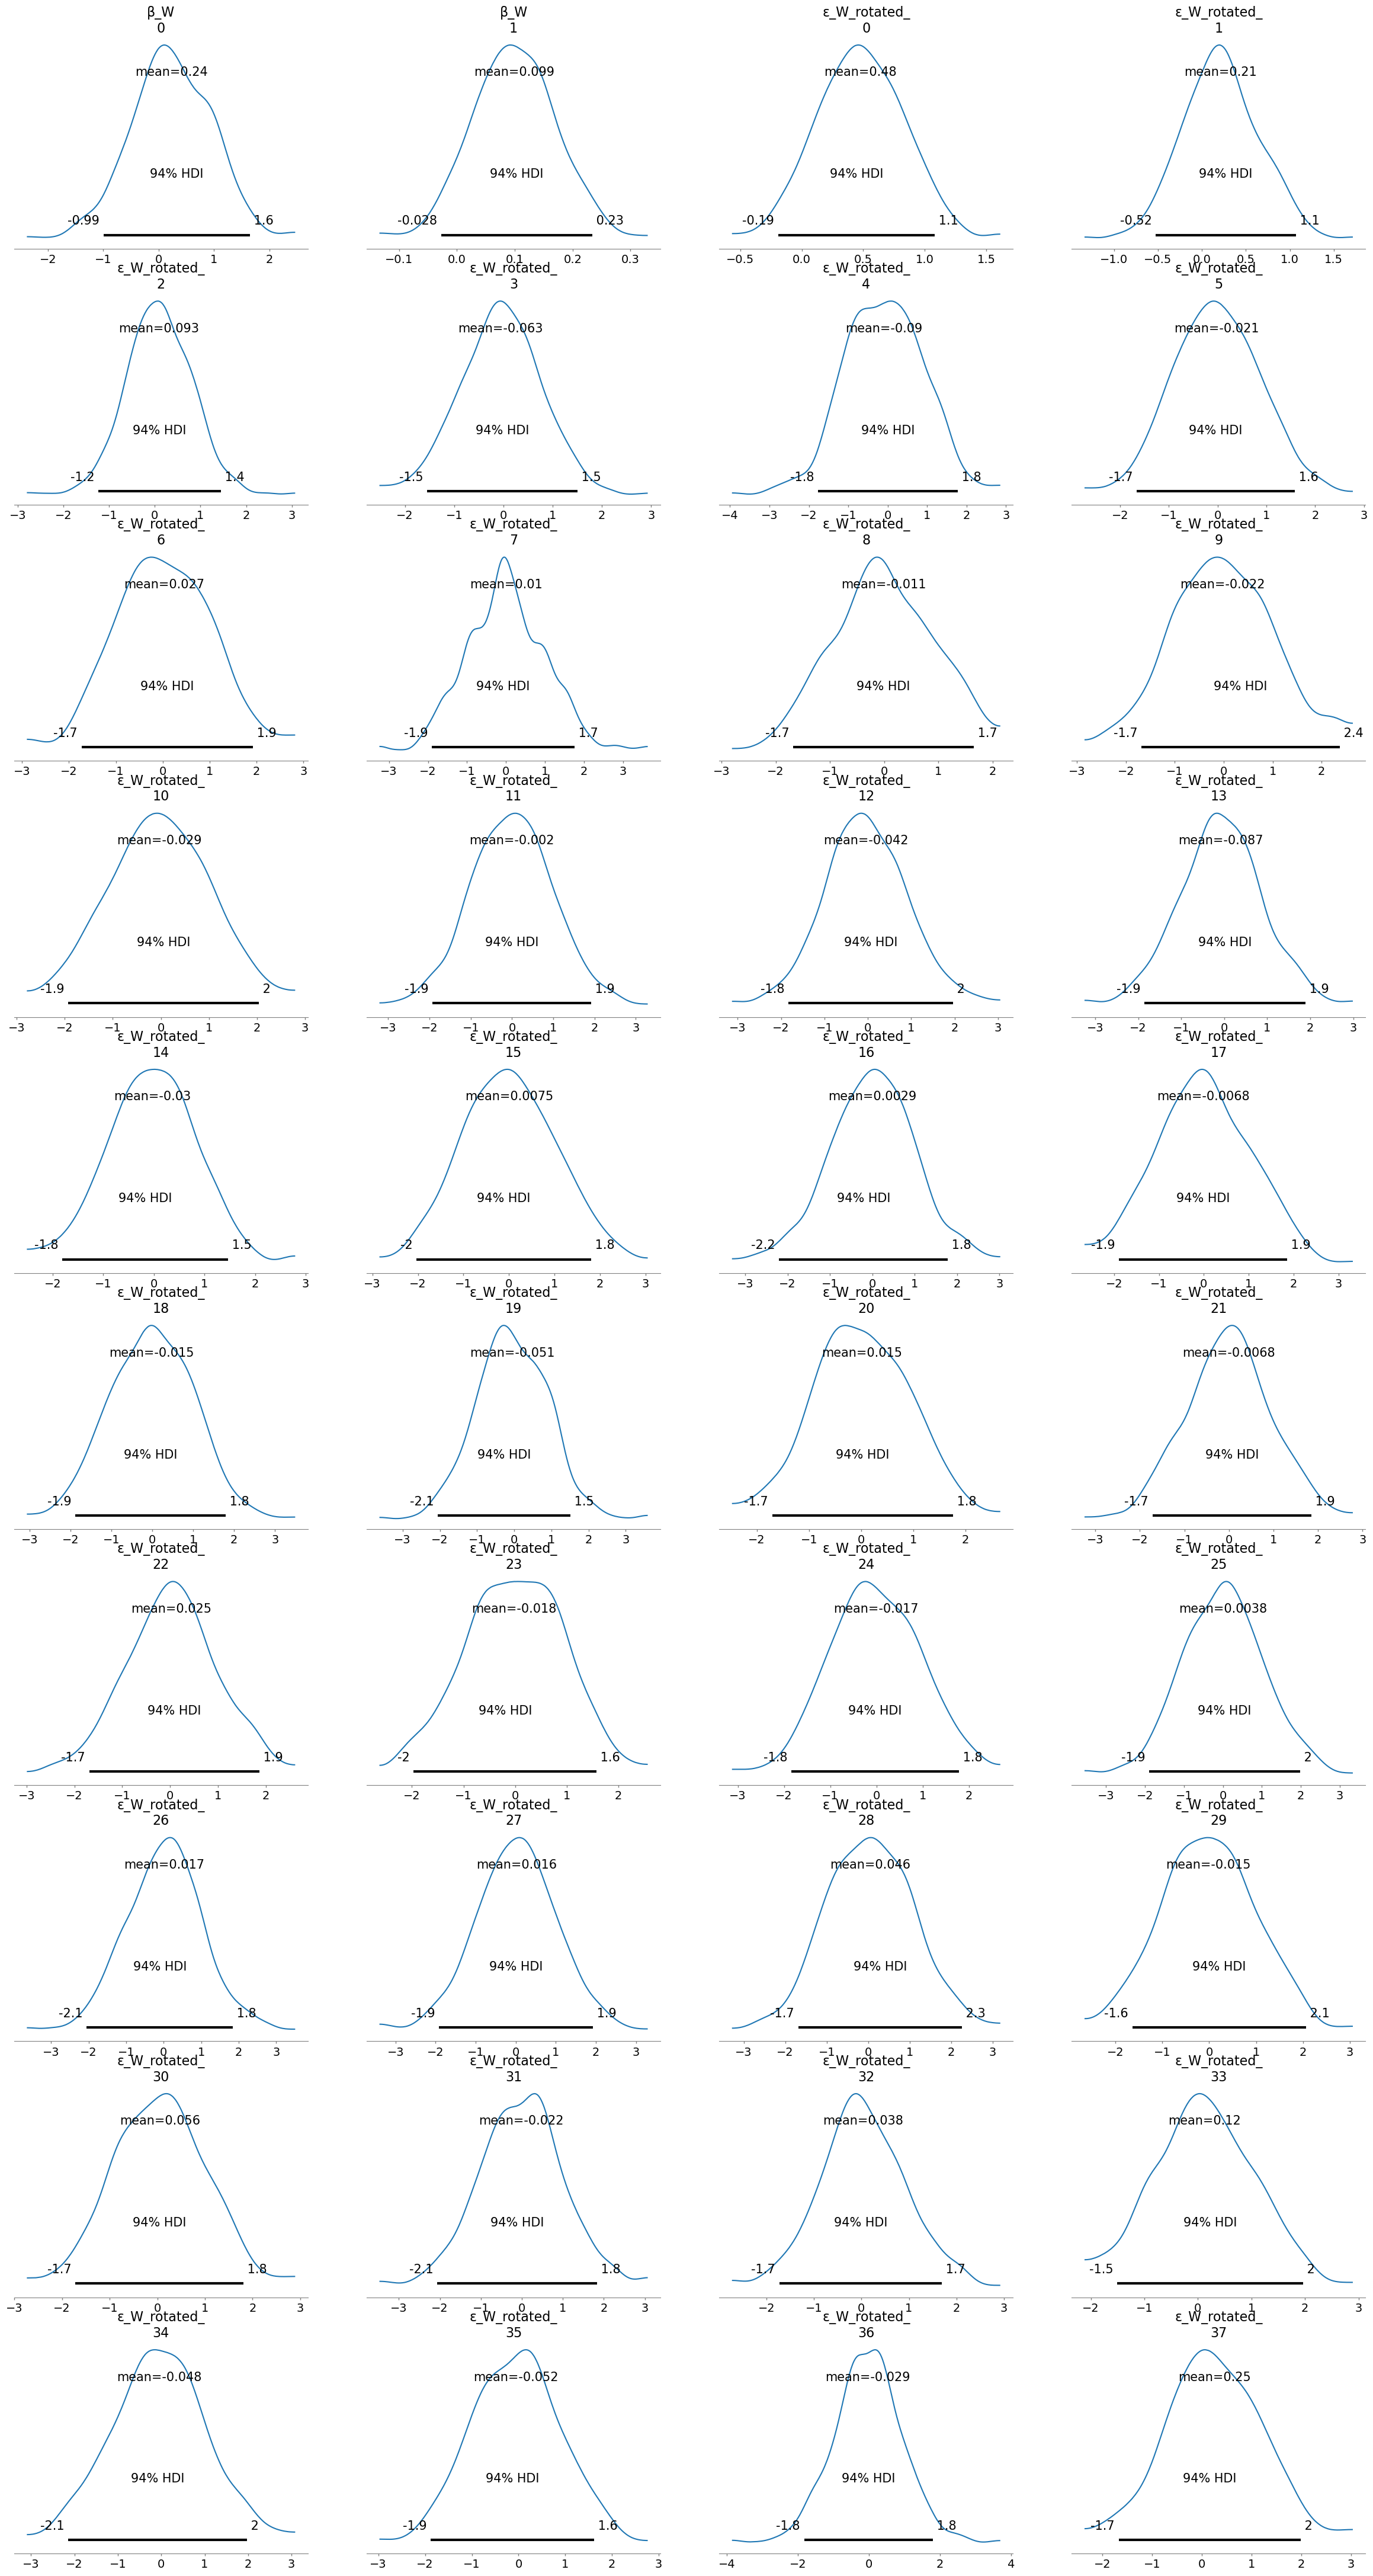

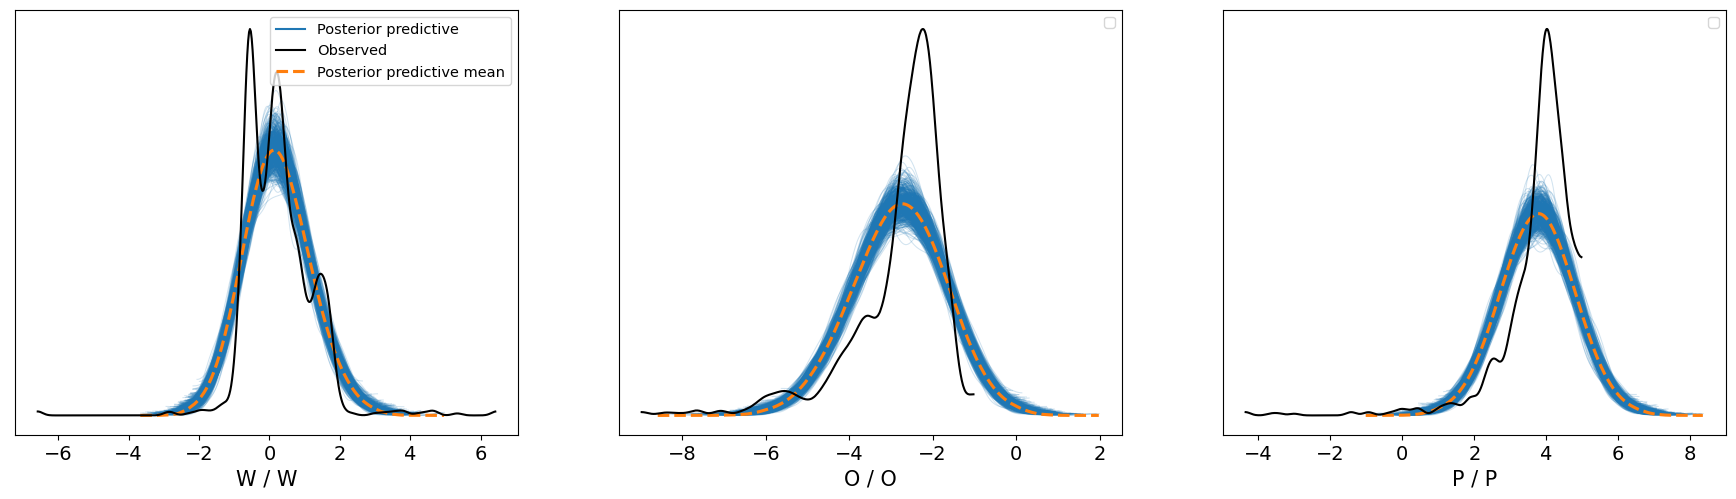

In [33]:
# az.plot_posterior(posterior_3)
# az.plot_trace(posterior_3)
# az.plot_forest(posterior_3, combined=False, hdi_prob=0.94)

az.plot_ppc(posterior_prediction_3)

In [22]:
with pm.Model() as model_4:
    W = pm.MutableData('W', data.income_per_capita)
    idx = data.is_old.astype(int)

    η_O = pm.Normal('η_O', 5)
    θ_O = pm.Normal('θ_O', 0.1)
    η_P = pm.Normal('η_P', 5)
    θ_P = pm.Normal('θ_P', 0.1)

    σ_α_O = pm.HalfNormal('σ_α_O', 1)
    σ_β_O = pm.HalfNormal('σ_β_O', 1)
    σ_α_P = pm.HalfNormal('σ_α_P', 1)
    σ_β_P = pm.HalfNormal('σ_β_P', 1)

    μ_α_P = pm.Normal('μ_α_P', η_P, σ_α_P, shape=2)
    μ_β_P = pm.Normal('μ_β_P', θ_P, σ_β_P, shape=2)
    μ_α_O = pm.Normal('μ_α_O', η_O, σ_α_O, shape=2)
    μ_β_O = pm.Normal('μ_β_O', θ_O, σ_β_O, shape=2)

    σ_α_O = np.array([0.1, 0.1])
    σ_β_O = np.array([0.1, 0.1])
    α_O = pm.Normal('α_O', μ_α_O, σ_α_O, shape=2)
    β_O = pm.Normal('β_O', μ_β_O, σ_β_O, shape=2)
    σ_O = pm.HalfNormal('σ_O', 0.1)
    O = pm.LogNormal('O', mu=α_O[idx] + β_O[idx] * W, sigma=σ_O, observed=data.orthodox)

    σ_α_P = np.array([0.1, 0.1])
    σ_β_P = np.array([0.1, 0.1])
    α_P = pm.Normal('α_P', μ_α_P, σ_α_P, shape=2)
    β_P = pm.Normal('β_P', μ_β_P, σ_β_P, shape=2)
    σ_P = pm.HalfNormal('σ_P', 0.1)
    P = pm.LogNormal('P', mu=α_P[idx] + β_P[idx] * W, sigma=σ_P, observed=data.population)

    prior_4 = pm.sample_prior_predictive()
    posterior_4 = pm.sample(draws=1000, tune=1000, init="adapt_diag", return_inferencedata=True, target_accept=0.9)
    posterior_prediction_4 = pm.sample_posterior_predictive(posterior_4)

graph_4 = pm.model_to_graphviz(model_4)
graph_4

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_O, θ_O, η_P, θ_P, σ_α_O, σ_β_O, σ_α_P, σ_β_P, μ_α_P, μ_β_P, μ_α_O, μ_β_O, α_O, β_O, σ_O, α_P, β_P, σ_P]


ValueError: Not enough samples to build a trace.

array([<AxesSubplot:xlabel='O / O'>, <AxesSubplot:xlabel='P / P'>],
      dtype=object)

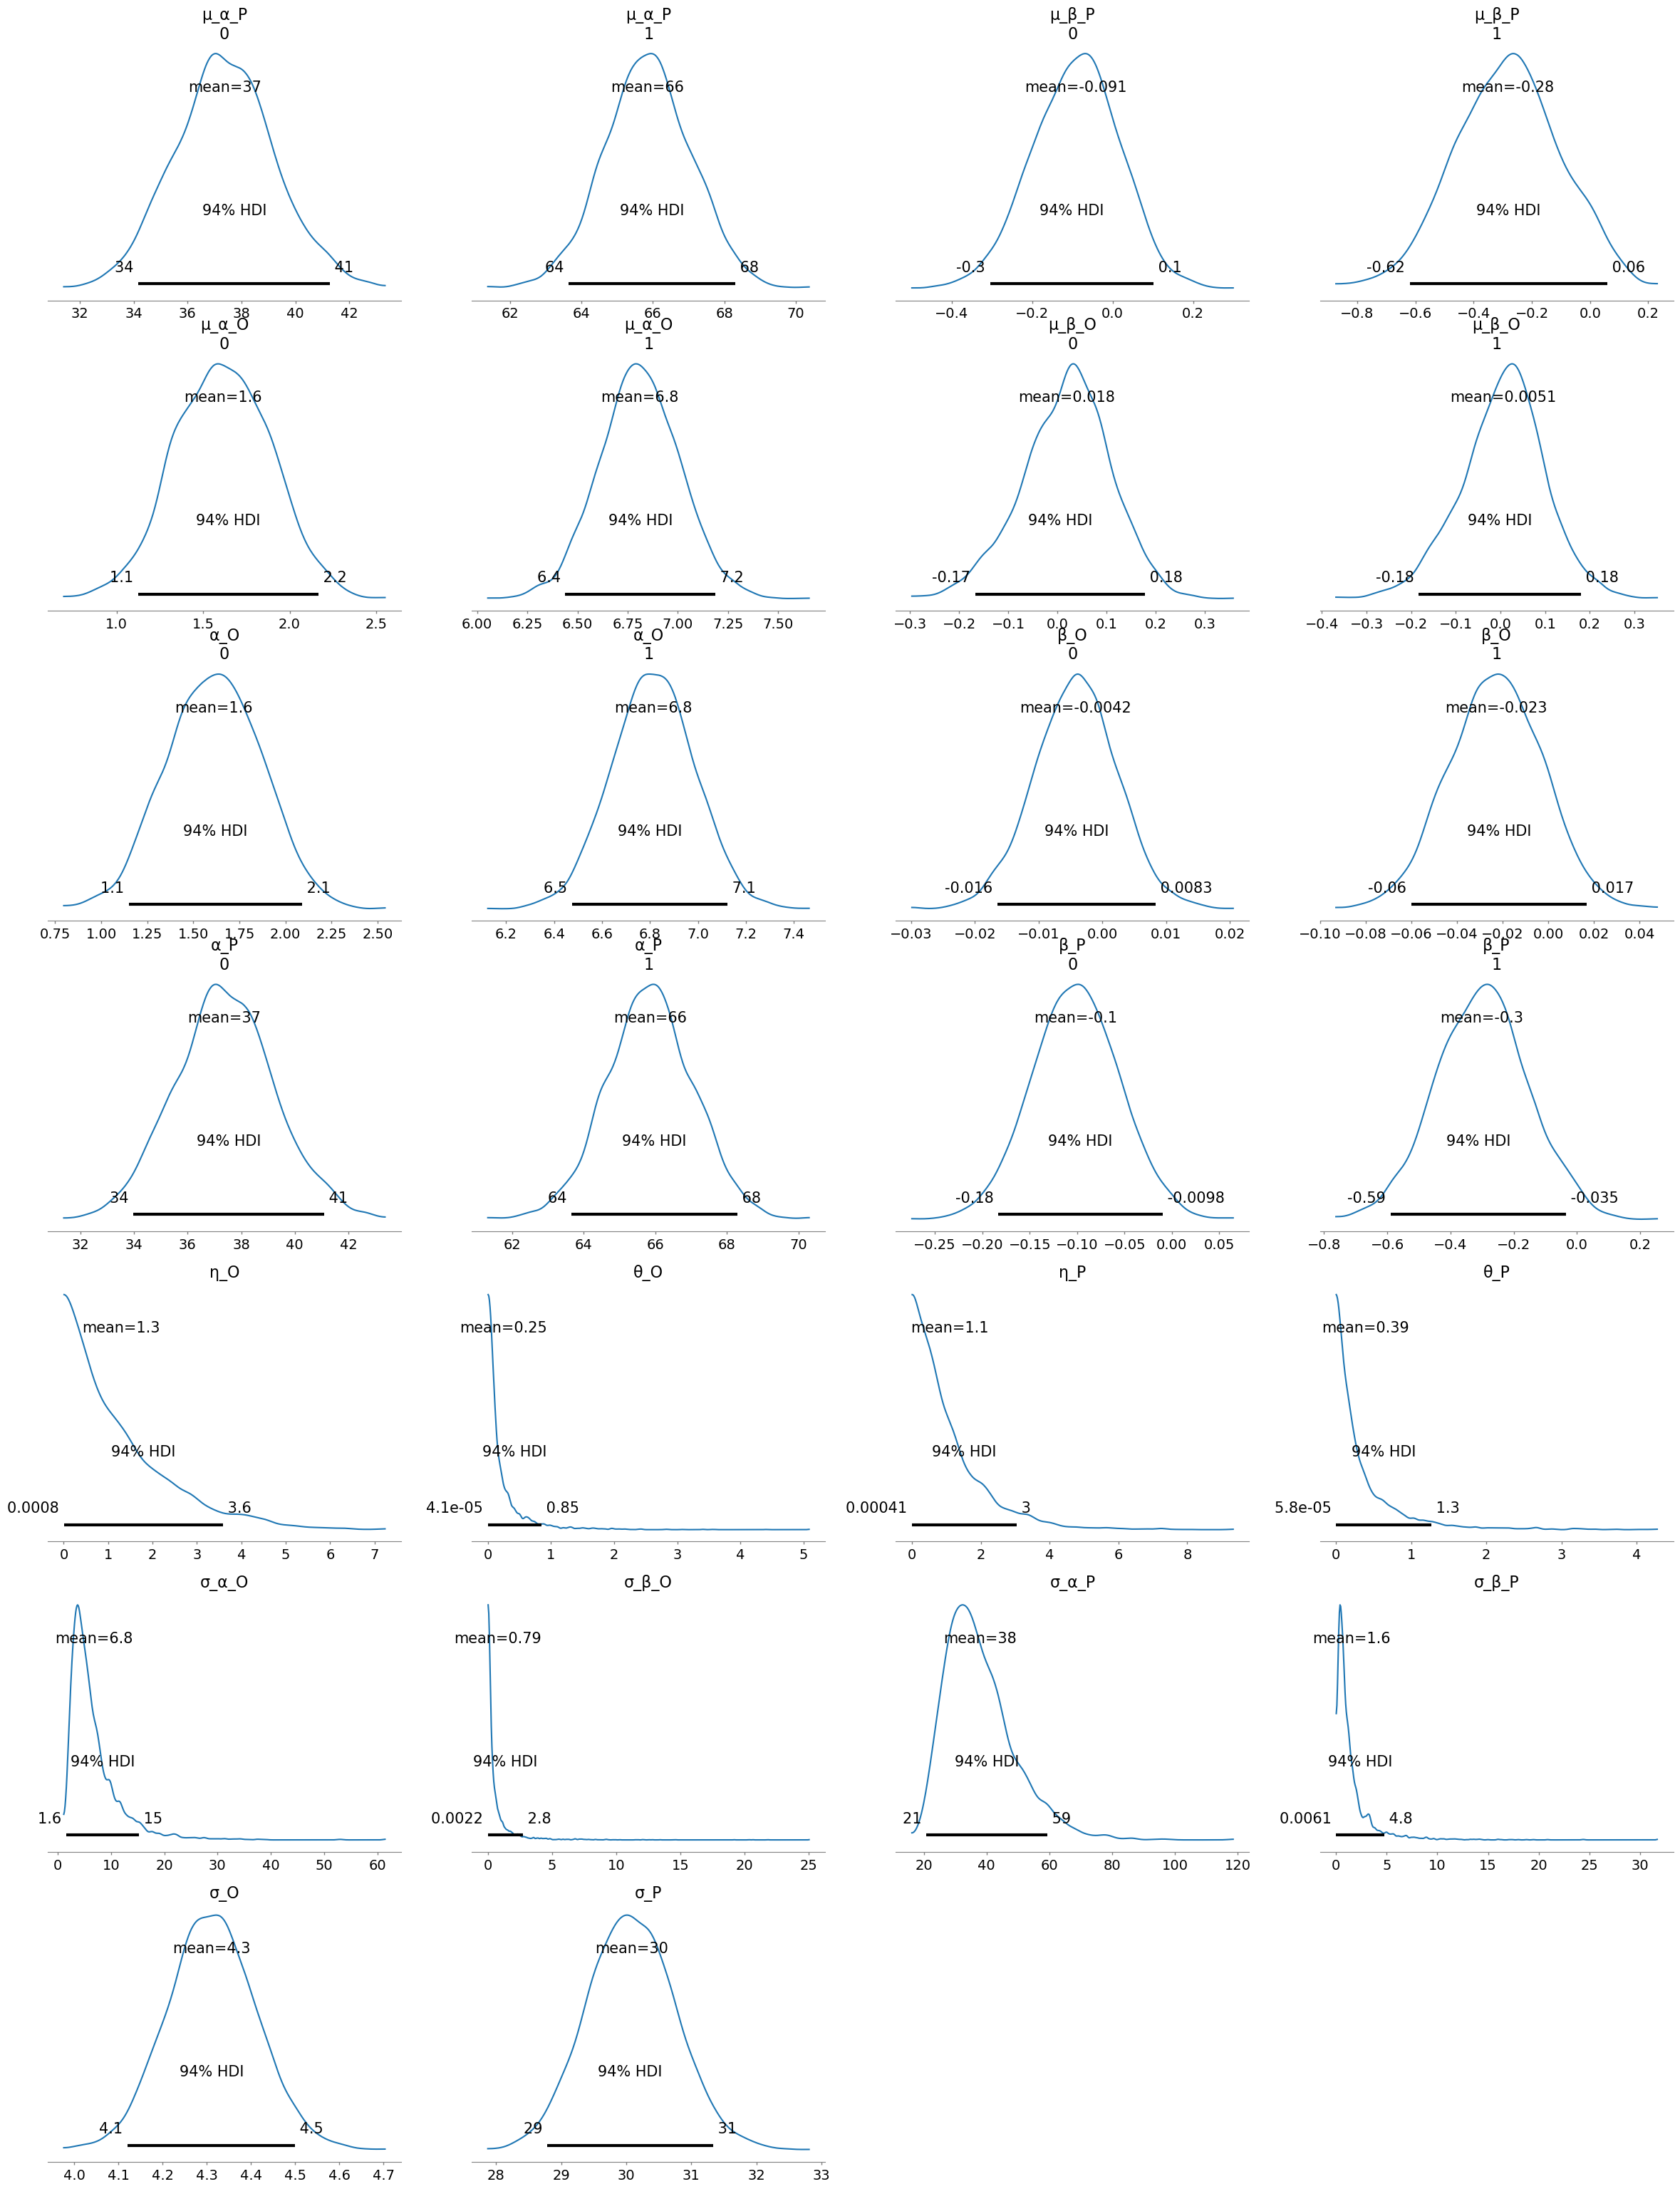

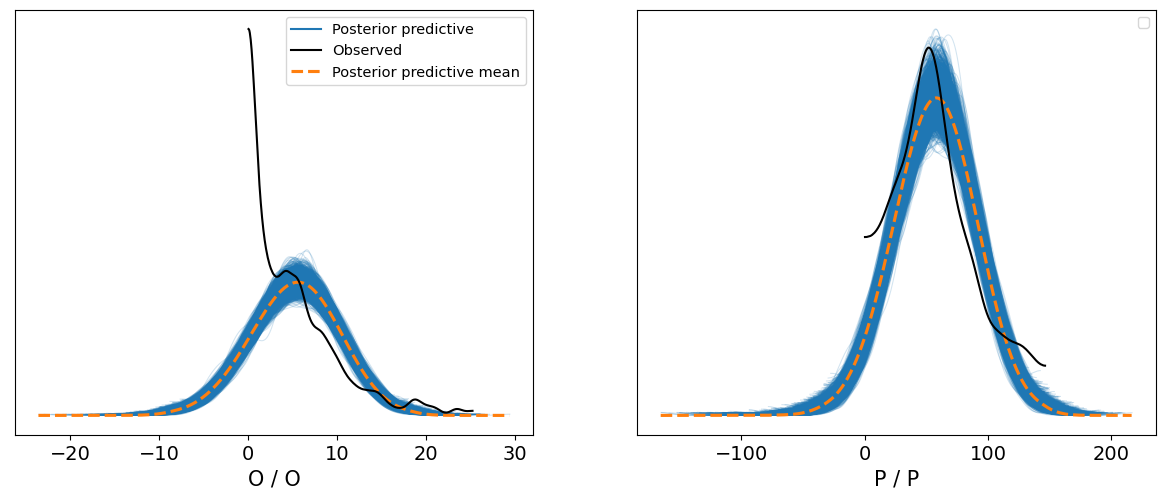

In [12]:
az.plot_posterior(posterior_4)
# az.plot_trace(posterior_4)
# az.plot_forest(posterior_4, combined=False, hdi_prob=0.94)

az.plot_ppc(posterior_prediction_4)